In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import h5py
import os
import time
from random import sample
import datetime
from collections import Counter
import sys

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten, Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import sparse_categorical_crossentropy
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import preprocessing
from tensorflow.keras.layers import Embedding, SimpleRNN
from keras.preprocessing.text import Tokenizer

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)
root_dir = '/content/gdrive/My Drive/'
base_dir = root_dir + 'Northwestern/Artificial Intelligence and Deep Learning/Assignment 3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from tensorflow.keras.datasets import reuters

voc_size = 10000

(train_data_raw, train_labels_raw), (test_data_raw, test_labels_raw) = reuters.load_data(num_words=voc_size)
word_index = reuters.get_word_index()
train_data_raw.shape, test_data_raw.shape

557056/550378 [==============================] - 0s 0us/step


((8982,), (2246,))

In [0]:
def top_label_data(X, y):

    topics_tpl, topics_freq = zip(*Counter(y).most_common(9))
    X_top, y_top = zip(*((x_samp, y_samp) for x_samp, y_samp in zip(X, y) if y_samp in topics_tpl))
    X_top, y_top = np.array(X_top), np.array(y_top)

    keys = Counter(y_top).keys()
    conv = dict(zip(sorted(keys), range(0,9)))
    y_top = [conv[l] for l in y_top]

    return X_top, y_top

In [0]:
def vectorize_sequences(sequences, dimension = voc_size):

    results = np.zeros((len(sequences), dimension))
    for i, sequence, in enumerate(sequences):
        results[i, sequence] = 1.

    return results

In [0]:
def max_len(train_data, train_labels, top = False):

    if top == False:
        pass

    elif top == True:
        train_data, train_labels = top_label_data(train_data, train_labels)

    train_data_len = [len(w) for w in train_data]
    maxlen = int(np.percentile(train_data_len, 80))

    return maxlen

In [0]:
def prepare_data(train_data, train_labels, test_data, test_labels,
                 top = False, embedding = False):

    if top == False:
        pass

    elif top == True:
        train_data, train_labels = top_label_data(train_data, train_labels)
        test_data, test_labels = top_label_data(test_data, test_labels)

    if embedding == False:
        train_data = vectorize_sequences(train_data)
        test_data = vectorize_sequences(test_data)
        maxlen = None
        
    elif embedding == True:
        maxlen = max_len(train_data, train_labels, top)
        train_data = preprocessing.sequence.pad_sequences(train_data, maxlen=maxlen)
        test_data = preprocessing.sequence.pad_sequences(test_data, maxlen=maxlen)

    train_data, val_data, train_labels, val_labels = train_test_split(
        train_data, train_labels, test_size = 0.15)
    train_labels = to_categorical(train_labels)
    val_labels = to_categorical(val_labels)
    test_labels = to_categorical(test_labels)

    return train_data, train_labels, val_data, val_labels, test_data, test_labels

In [0]:
def tensor_slices(train_data, train_labels, val_data, val_labels, test_data, test_labels):

    train_ds = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).shuffle(100).batch(100)
    val_ds = tf.data.Dataset.from_tensor_slices((val_data, val_labels)).batch(100)
    test_ds = tf.data.Dataset.from_tensor_slices((test_data, test_labels))

    return train_ds, val_ds, test_ds

In [0]:
def embedding_matrix(embedding_file):

    embeddings_index = {}
    f = open(os.path.join(base_dir, embedding_file))
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype = 'float32')
        embeddings_index[word] = coefs
    f.close()
    print(f'Found {len(embeddings_index)} word vectors')

    embedding_dim = int(embedding_file.split('.')[-2].replace('d', ''))

    embedding_matrix = np.zeros((voc_size, embedding_dim))
    for word, i in word_index.items():
        if i < voc_size:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

    return embedding_matrix, embedding_dim

In [0]:
def build_model_1(top, maxlen, pretrained_embed = False):

    if top == False:
        topics = 46
    
    elif top == True:
        topics = 9

    model = Sequential()

    if pretrained_embed == True:
        embedding_file = 'glove.6B.100d.txt'
        embed_matrix, embed_dim = embedding_matrix(embedding_file)
        model.layers[0].set_weights([embed_matrix])
        model.layers[0].trainable = False
        output_dim = embed_dim
    elif pretrained_embed == False:
        output_dim = 128

    model.add(Embedding(input_dim = voc_size, output_dim = output_dim, input_length = maxlen))
    model.add(SimpleRNN(units = 64, activation = 'tanh'))
    model.add(Dense(units = topics, activation = 'softmax'))

    model.compile(
                    optimizer = 'rmsprop',
                    loss = 'categorical_crossentropy',
                    metrics = ['accuracy'])

    return model

In [0]:
def build_model_2(top, maxlen, pretrained_embed = False):

    if top == False:
        topics = 46
    
    elif top == True:
        topics = 9

    model = Sequential()

    if pretrained_embed == True:
        embedding_file = 'glove.6B.100d.txt'
        embed_matrix, embed_dim = embedding_matrix(embedding_file)
        model.layers[0].set_weights([embed_matrix])
        model.layers[0].trainable = False
        output_dim = embed_dim
    elif pretrained_embed == False:
        output_dim = 128

    model.add(Embedding(input_dim = voc_size, output_dim = output_dim, input_length = maxlen))
    model.add(SimpleRNN(units = 64, activation = 'tanh', return_sequences=True))
    model.add(SimpleRNN(units = 32, activation = 'tanh'))    
    model.add(Dense(units = topics, activation = 'softmax'))

    model.compile(
                    optimizer = 'rmsprop',
                    loss = 'categorical_crossentropy',
                    metrics = ['accuracy'])

    return model

In [0]:
train_data, train_labels, val_data, val_labels, test_data, test_labels = prepare_data(
        train_data_raw, train_labels_raw, test_data_raw, test_labels_raw, top = True, embedding = True)

In [0]:
def build_embed_model(top, train_data, train_labels):

    if top == False:
        topics = 46
    
    elif top == True:
        topics = 9

    maxlen = max_len(train_data, train_labels, top = top)

    model = Sequential()
    model.add(Embedding(input_dim = voc_size, output_dim = 256, input_length = maxlen))
    model.add(Flatten())
    model.add(Dense(units = 9, activation = 'sigmoid'))

    model.compile(
                    optimizer = 'rmsprop',
                    loss = 'binary_crossentropy',
                    metrics = ['accuracy'])

    return model

In [0]:
def model_train(features, labels, model):
    
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = loss_func(labels, predictions)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss.update_state(loss)
    train_acc.update_state(labels, predictions)

    return gradients

In [0]:
def model_validate(features, labels, model):
    
    predictions = model(features)
    v_loss = loss_func(labels, predictions)

    valid_loss.update_state(v_loss)
    valid_acc.update_state(labels, predictions)

In [0]:
train_loss = tf.keras.metrics.Mean(name="train_loss")
valid_loss = tf.keras.metrics.Mean(name="test_loss")
test_loss = tf.keras.metrics.CategoricalCrossentropy(name="test_loss")

train_acc = tf.keras.metrics.CategoricalAccuracy(name="train_acc")
valid_acc = tf.keras.metrics.CategoricalAccuracy(name="valid_acc")
test_acc = tf.keras.metrics.CategoricalAccuracy(name="test_acc")

loss_func = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.RMSprop()

In [0]:
def model_run(model, train_data, train_labels, test_data, test_labels, 
              top = False, embedding = False, pretrained_embed = False):
    
    keras.backend.clear_session()

    train_data, train_labels, val_data, val_labels, test_data, test_labels = prepare_data(
        train_data, train_labels, test_data, test_labels, top = top, embedding = embedding)
    train_data, val_data, test_slice = tensor_slices(train_data, train_labels, 
                                                    val_data, val_labels, 
                                                    test_data, test_labels)
    

    EPOCHS = 30
    train_acc_history = []
    train_loss_history = []
    val_acc_history = []
    val_loss_history = []
    weight_history = []
    elapsed_time_tot = []
    gradients = []

    for epoch in range(EPOCHS):

        start_time = time.time()
        for features, labels in train_data:
            grad = model_train(features, labels, model)
        gradients.append(grad)
        
        for val_features, val_labels in val_data:
            model_validate(val_features, val_labels, model)

        loss, acc = train_loss.result(), train_acc.result()
        val_loss, val_acc = valid_loss.result(), valid_acc.result()

        train_acc_history.append(acc.numpy())
        train_loss_history.append(loss.numpy())
        val_acc_history.append(val_acc.numpy())
        val_loss_history.append(val_loss.numpy())
        weight_history.append([layer.get_weights() for layer in model.layers])

        train_loss.reset_states(), train_acc.reset_states()
        valid_loss.reset_states(), valid_acc.reset_states()

        end_time = time.time()
        elapsed_time = end_time - start_time
        elapsed_time_tot.append(elapsed_time)
        
        template = """Epoch {}, loss: {:.3f}, acc: {:.3f}, val_loss: {:.3f}, val_acc: {:.3f}, elapsed time: {:.3f}"""
        print (template.format(epoch+1,
                            loss,
                            acc,
                            val_loss,
                            val_acc,
                            elapsed_time))
        
    elapsed_time_tot = [sum(elapsed_time_tot[0:x:1]) for x in range(1, EPOCHS+1)]
        
    predictions = model(test_data, training = False)
    t_acc = test_acc(test_labels, predictions)
    t_loss = loss_func(test_labels, predictions)   
    print(f'Test accuracy: {t_acc:.3f}, Test loss: {t_loss:.3f}')    
               
        
    performance = {
        'train_acc': train_acc_history,
        'train_loss': train_loss_history,
        'val_acc': val_acc_history,
        'val_loss': val_loss_history,
        'test_acc': t_acc.numpy(),
        'test_loss': t_loss.numpy(),   
        'elapsed_time': elapsed_time_tot
    }
        
    return model, weight_history, performance, gradients

In [0]:
top = True
embedding = True
pretrained_embed = False
maxlen = max_len(train_data_raw, train_labels_raw, top = top)
model_2, weight_history, performance, grads = model_run(build_model_2(top, maxlen), 
    train_data_raw, train_labels_raw, test_data_raw, test_labels_raw, top = top, 
    embedding = embedding, pretrained_embed = pretrained_embed)

Epoch 1, loss: 1.520, acc: 0.519, val_loss: 1.374, val_acc: 0.547, elapsed time: 33.348
Epoch 2, loss: 0.922, acc: 0.712, val_loss: 1.124, val_acc: 0.661, elapsed time: 33.098
Epoch 3, loss: 0.470, acc: 0.891, val_loss: 1.137, val_acc: 0.661, elapsed time: 33.342
Epoch 4, loss: 0.247, acc: 0.952, val_loss: 1.368, val_acc: 0.607, elapsed time: 33.016
Epoch 5, loss: 0.155, acc: 0.963, val_loss: 1.426, val_acc: 0.622, elapsed time: 32.891
Epoch 6, loss: 0.118, acc: 0.968, val_loss: 1.522, val_acc: 0.595, elapsed time: 32.863
Epoch 7, loss: 0.098, acc: 0.969, val_loss: 1.568, val_acc: 0.596, elapsed time: 33.003
Epoch 8, loss: 0.090, acc: 0.971, val_loss: 1.649, val_acc: 0.602, elapsed time: 33.253
Epoch 9, loss: 0.071, acc: 0.977, val_loss: 1.742, val_acc: 0.582, elapsed time: 32.961
Epoch 10, loss: 0.064, acc: 0.977, val_loss: 1.760, val_acc: 0.605, elapsed time: 32.909
Epoch 11, loss: 0.065, acc: 0.975, val_loss: 1.770, val_acc: 0.584, elapsed time: 32.825
Epoch 12, loss: 0.062, acc: 0.

In [0]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 193, 128)          1280000   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                12352     
_________________________________________________________________
dense (Dense)                (None, 9)                 585       
Total params: 1,292,937
Trainable params: 1,292,937
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 193, 128)          1280000   
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 193, 64)           12352     
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 32)                3104      
_________________________________________________________________
dense (Dense)                (None, 9)                 297       
Total params: 1,295,753
Trainable params: 1,295,753
Non-trainable params: 0
_________________________________________________________________


In [0]:
def df_performance(performance, model_desc):

    df_performance = pd.DataFrame(performance).iloc[-1:]
    df_performance.insert(0, 'model', model_desc)
    file_path = os.path.join(base_dir, 'performance_table.csv')

    if os.path.exists(file_path):
        df_performance_tot = pd.read_csv(file_path)
        df_performance = pd.concat([df_performance_tot, df_performance])
    else:
        pass

    df_performance.to_csv(file_path, index = False)

    return df_performance.round(3)

In [0]:
df_performance(performance, 'Deep RNN w/ embed Top 9')

,model,train_acc,train_loss,val_acc,val_loss,test_acc,test_loss,elapsed_time
0,DNN (2 layers) Top 9,0.961,0.068,0.860,0.984,0.833,1.166,63.696
1,DNN (2 layers) w/ do Top 9,0.966,0.057,0.836,1.329,0.838,1.186,59.811
2,DNN (2 layers) w/ embed Top 9,0.970,0.048,0.761,1.311,0.809,1.434,122.008
3,DNN (2 layers) w/ embed & drop Top 9,0.971,0.047,0.774,1.389,0.799,1.352,116.190
4,Simple RNN w/ embed,0.981,0.048,0.591,2.012,0.604,1.738,557.336
29,Deep RNN w/ embed Top 9,0.974,0.054,0.604,1.922,0.611,1.875,990.383


In [0]:
def plot_results(performance):

    epochs = range(1, len(performance['train_acc']) + 1)

    fig, ax = plt.subplots(1,2, figsize = [15, 6])
    ax[0].plot(epochs, performance['train_loss'], 'bo', label = 'Training loss')
    ax[0].plot(epochs, performance['val_loss'], 'b', label = 'Validation loss')

    ax[0].set_title('Training and Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    ax[1].plot(epochs, performance['train_acc'], 'bo', label = 'Training accuracy')
    ax[1].plot(epochs, performance['val_acc'], 'b', label = 'Validation accuracy')

    ax[1].set_title('Training and Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

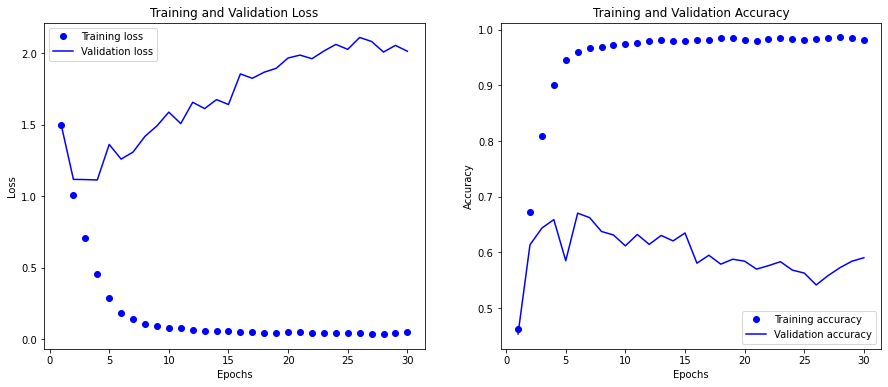

In [0]:
#Model 1
plot_results(performance)

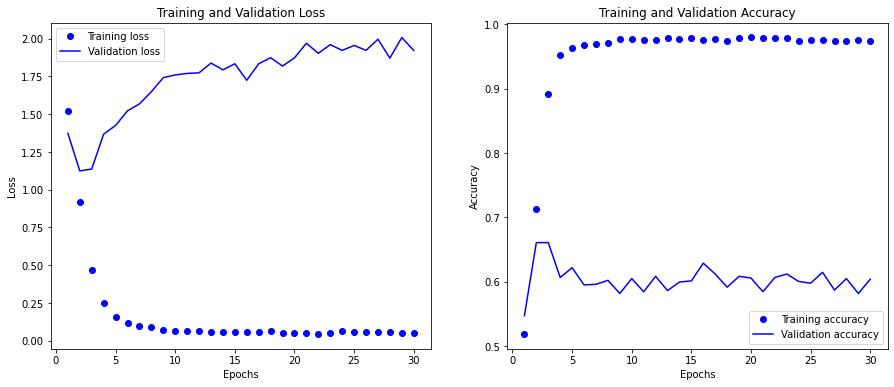

In [0]:
#Model 2
plot_results(performance)

In [0]:
def plot_gradients(grads, layer):

    epochs = len(grads)
    prior_layer_num = sample(range(grads[0][layer].shape[0]),1)
    current_lay_num = range(grads[0][layer].shape[1])
    for current_layer in sample(current_lay_num,5):
        grad = []
        for epoch in range(epochs):
            value = grads[epoch][layer][prior_layer_num][current_layer].numpy()
            grad.append(value)

        plt.plot(grad)

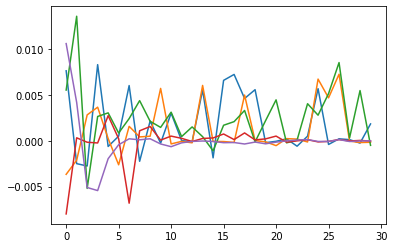

In [0]:
#Model 1
plot_gradients(grads, 4)

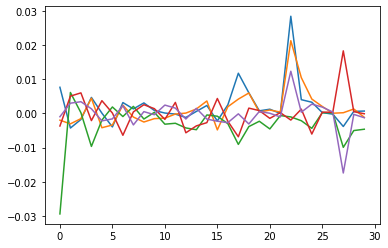

In [0]:
#Model 2
plot_gradients(grads, 4)

In [0]:
def return_final_parameters(model, X):
    
    layer_outputs = [layer.output for layer in model.layers]
    activation_model = tf.keras.Model(inputs = model.input, outputs = layer_outputs)
    activations = activation_model.predict(X)

    weights = [layer.get_weights() for layer in model.layers]
    return activations, weights

In [0]:
def plot_weights(weight_history, layer, model):
    
    num_weights = np.shape(weight_history[0][layer][0])[0]
    num_neurons = np.shape(weight_history[0][layer][0])[1]
    epochs = len(weight_history)
    weights_to_plot = {}
    num_plots = 5
    fig, ax = plt.subplots(1, num_plots, figsize = [20, 6])
    for axes in range(num_plots):
        for weight in sample(list(np.arange(0, num_weights, 1)), 1):
            for neuron in list(np.arange(0, num_neurons, 1)):
                weight_id = f'N{neuron}_W{weight}'
                weights_to_plot[weight_id] = []
                for epoch in range(epochs-1):
                    weights_to_plot[weight_id].append(weight_history[epoch][layer][0][weight][neuron])
                ax[axes].plot(weights_to_plot[weight_id], label = weight_id)
                # ax[axes].legend()
                ax[axes].set_xlabel('Epoch')
                ax[axes].set_ylabel('Weight Value')
                ax[axes].set_title(f'Weight {weight} Per Neuron and Epoch')

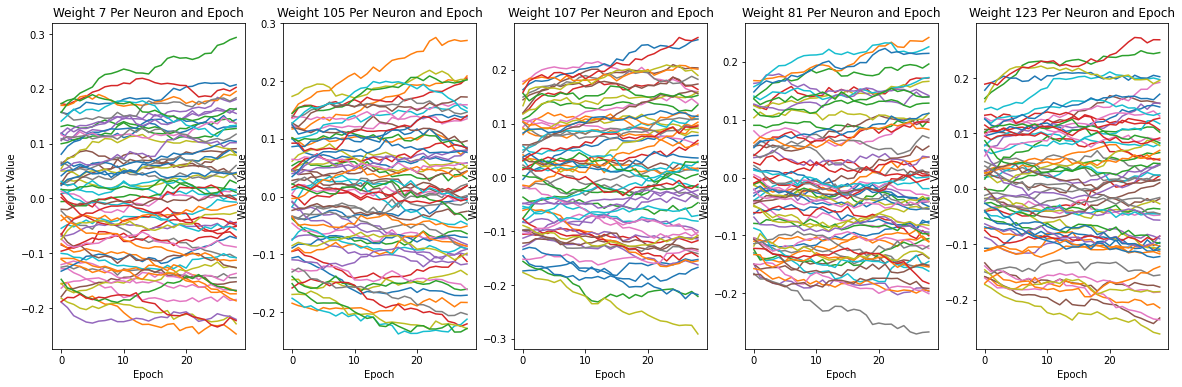

In [0]:
#Model 1
plot_weights(weight_history, 1, model_1)

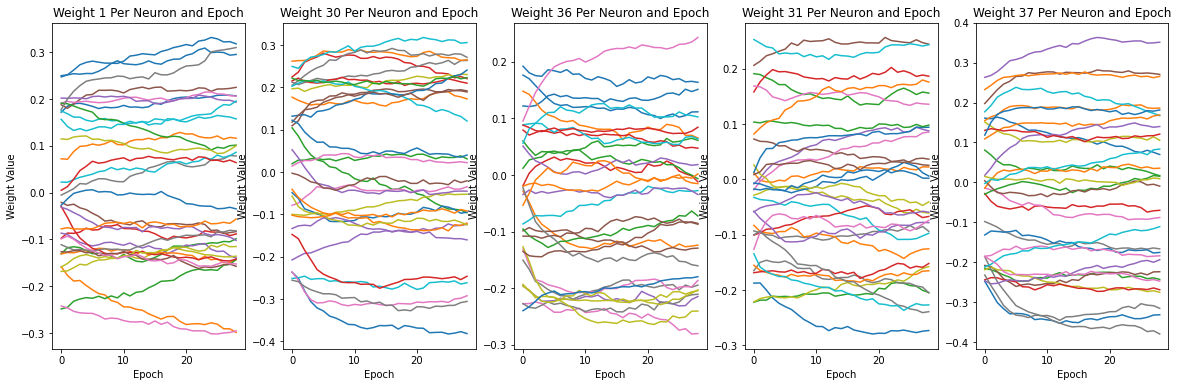

In [0]:
#Model 2
plot_weights(weight_history, 2, model_1)